In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import torch.nn
import os
import sys
import importlib
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from rff.layers import GaussianEncoding #pip install random-fourier-features-pytorch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
# sys.path.append('../../model/')
# from updatedModel import CATTransformer, train, test
import time

# Run regardless if you do or do not have GPU so all tensors are moved to right location later on
if torch.cuda.is_available():
    device_in_use = torch.device("cuda")
    print("GPU is available and being used")
else:
    device_in_use = torch.device("cpu")
    print("GPU is not available, using CPU instead")

df_train = pd.read_csv('../../datasets/helena/train.csv')
df_test = pd.read_csv('../../datasets/helena/test.csv')
df_val = pd.read_csv('../../datasets/helena/validation.csv') #READ FROM RIGHT SPOT

# class,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet1pt,jet1eta,jet1phi,jet1b-tag,
# jet2pt,jet2eta,jet2phi,jet2b-tag,jet3pt,jet3eta,jet3phi,jet3b-tag,jet4pt,jet4eta,jet4phi,jet4b-tag,m_jj,m_jjj,m_lv,
# m_jlv,m_bb,m_wbb,m_wwbb



GPU is not available, using CPU instead


In [2]:
def categorize_columns(dataframe, target):
    categorical_columns = []
    continuous_columns = []
    unique_classes_per_column = []  # To hold the number of unique classes for each categorical column

    for column in dataframe.columns:
        if dataframe[column].dtype == 'object' or len(dataframe[column].unique()) <= 10:
            # If the column's data type is 'object' or it has 10 or fewer unique values, consider it categorical.
            if column != target:
                categorical_columns.append(column)
                unique_classes_per_column.append(dataframe[column].nunique())  # Store the number of unique classes
        else:
            # Otherwise, consider it continuous.
            continuous_columns.append(column)

    return categorical_columns, continuous_columns, unique_classes_per_column

In [4]:
target = 'class'
cat_columns, cont_columns, unique_classes_per_column = categorize_columns(df_train, target)

if target in cont_columns:
    cont_columns.remove(target)
elif target in cat_columns:
    print("in here")
    cat_columns.remove(target)

print("Target:", target)
print("Categorical: ", cat_columns)
print("Continous: ", cont_columns)
print("Unique Classes per Column: ", unique_classes_per_column)


#CHECKING TO MAKE SURE YOUR LIST IS CORRECT (NO NEED TO TOUCH)
yourlist = cat_columns + cont_columns + [target]
yourlist.sort()
oglist = list(df_train.columns)
oglist.sort()

assert(yourlist == oglist), "You may of spelled feature name wrong or you forgot to put on of them in the list"

target_classes = [max(len(df_train[target].value_counts()), len(df_val[target].value_counts()),len(df_test[target].value_counts()))]
print(target_classes)
# Create a StandardScaler and fit it to the cont features
scaler = StandardScaler()
scaler.fit(df_train[cont_columns])

# Transform the training, test, and validation datasets
df_train[cont_columns] = scaler.transform(df_train[cont_columns])
df_test[cont_columns] = scaler.transform(df_test[cont_columns])
df_val[cont_columns] = scaler.transform(df_val[cont_columns])

class SingleTaskDataset(Dataset):
    def __init__(self, df : pd.DataFrame, cat_columns, num_columns,task1_column):
        self.n = df.shape[0]
        
        self.task1_labels = df[task1_column].astype(np.float32).values

        self.cate = df[cat_columns].astype(np.int64).values
        self.num = df[num_columns].astype(np.float32).values


    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        # Retrieve features and labels from the dataframe using column names
        cat_features = self.cate[idx]
        num_features = self.num[idx]
        labels_task1 = self.task1_labels[idx]

        return cat_features, num_features, labels_task1

#Wrapping in Dataset
train_dataset = SingleTaskDataset(df_train, cat_columns, cont_columns, 'class')
val_dataset = SingleTaskDataset(df_val, cat_columns, cont_columns, 'class')
test_dataset = SingleTaskDataset(df_test, cat_columns, cont_columns, 'class')

#This is a hyperparameter that is not tuned. Maybe mess with what makes sense here
#Also try looking to see what other papers have done
batch_size = 256

# Wrapping with DataLoader for easy batch extraction
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Target: class
Categorical:  []
Continous:  ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27']
Unique Classes per Column:  []
[100]


In [5]:
import torch
import torch.nn as nn
from rff.layers import GaussianEncoding
from sklearn.metrics import accuracy_score, f1_score, recall_score
    
#All layers of the model
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadAttention, self).__init__()

        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        assert(self.head_dim * heads == embed_size), "Embed size needs to be div by heads"
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys =nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads*self.head_dim, embed_size)


    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3) #(batch_size, head_dim, #query_embeddings, #key_embeddings)

        # Calculate simplified attention scores
        avg_attention = attention.mean(dim=0)  # Average across batches
        # print("batch average", avg_attention.shape)
        avg_attention = avg_attention.mean(dim=0).squeeze(dim=0)
        # print("head average", avg_attention.shape)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads*self.head_dim) #(batch_size, n_features, embed_size)
        out = self.fc_out(out)

        return out, avg_attention
    
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion, pre_norm_on):
        super(TransformerBlock, self).__init__()

        self.pre_norm_on = pre_norm_on
        if self.pre_norm_on:
            self.pre_norm = nn.LayerNorm(embed_size)
        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(nn.Linear(embed_size, forward_expansion*embed_size),
                                          nn.ReLU(),
                                          nn.Linear(forward_expansion*embed_size, embed_size)
                                          )
        self.dropout = nn.Dropout(dropout)

    def forward(self,value,key,query):
        if self.pre_norm_on:
            query = self.pre_norm(query)
            key = self.pre_norm(key)
            value = self.pre_norm(value)
            
        attention, avg_attention = self.attention(value, key, query)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out, avg_attention
    
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, pre_norm_on):
        super(DecoderBlock, self).__init__()

        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(embed_size, heads, dropout, forward_expansion, pre_norm_on)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key):
        out, avg_attention = self.transformer_block(value, key, x)

        return out, avg_attention

class Decoder(nn.Module):
    def __init__(self,
                 embed_size,
                 num_layers,
                 heads,
                 forward_expansion,
                 decoder_dropout,
                 pre_norm_on
    ):
        super(Decoder, self).__init__()

        self.layers = nn.ModuleList(
                [
                    DecoderBlock(
                        embed_size,
                        heads,
                        dropout=decoder_dropout,
                        forward_expansion=forward_expansion,
                        pre_norm_on=pre_norm_on
                    )
                    for _ in range(num_layers)
                ]
            )
        self.avg_attention = None

    def forward(self, class_embed, context):
        for layer in self.layers:
            # x is the classification embedding (CLS Token)
            # context are the feature embeddings that will be used as key and value
            x, self.avg_attention = layer(class_embed, context, context)
  
        return x 

class Embeddings(nn.Module):
    def __init__(self, sigma, embed_size, input_size, embedding_dropout, n_cont, cat_feat, num_target_labels, rff_on):
        super(Embeddings, self).__init__()

        self.rff_on = rff_on

        if self.rff_on:
            self.rffs = nn.ModuleList([GaussianEncoding(sigma=sigma, input_size=input_size, encoded_size=embed_size//2) for _ in range(n_cont)])
            self.dropout = nn.Dropout(embedding_dropout)
            self.mlp_in = embed_size
        else:
            self.mlp_in = input_size

        self.cont_embeddings = nn.ModuleList([nn.Linear(in_features=self.mlp_in, out_features=embed_size) for _ in range(n_cont)])

        self.cat_embeddings = nn.ModuleList([nn.Embedding(num_classes, embed_size) for num_classes in cat_feat])

        # Classifcation Embeddings for each target label
        self.target_label_embeddings = nn.ModuleList([nn.Embedding(1, embed_size) for _ in range(num_target_labels)])


    def forward(self, cat_x, cont_x):
        x = cont_x.unsqueeze(2) #(batch_size, n_features) -> (batch_size, n_features, 1)
        rff_vectors = []
        if self.rff_on:
            for i, r in enumerate(self.rffs):
                input = x[:,i,:]
                out = r(input)
                rff_vectors.append(out)
        
            x = torch.stack(rff_vectors, dim=1)
        
        embeddings = []
        for i, e in enumerate(self.cont_embeddings):
            goin_in = x[:,i,:]
            goin_out = e(goin_in)
            embeddings.append(goin_out)

        #embedding cat features
        cat_x = cat_x.unsqueeze(2)
        for i, e in enumerate(self.cat_embeddings):
            print(cat_x.shape)
            print(cat_x[:, i, :])
            goin_in = cat_x[:,i,:]
  
            goin_out = e(goin_in)
            goin_out=goin_out.squeeze(1)
            embeddings.append(goin_out)

        target_label_embeddings_ = []
        for e in self.target_label_embeddings:
            input = torch.tensor([0], device=x.device)
            temp = e(input)
            temp = temp.repeat(x.size(0), 1)
            tmep = temp.unsqueeze(1)
            target_label_embeddings_.append(temp)

        class_embeddings = torch.stack(target_label_embeddings_, dim=1)

        context = torch.stack(embeddings, dim=1)

        return class_embeddings, context

class classificationHead(nn.Module):
    def __init__(self, embed_size, dropout, mlp_scale_classification, num_target_classes):
        super(classificationHead, self).__init__()
        
        #flattening the embeddings out so each sample in batch is represented with a 460 dimensional vector
        self.input = embed_size
        self.lin1 = nn.Linear(self.input, mlp_scale_classification*self.input)
        self.drop = nn.Dropout(dropout)
        self.lin2 = nn.Linear(mlp_scale_classification*self.input, mlp_scale_classification*self.input)
        self.lin3 = nn.Linear(mlp_scale_classification*self.input, self.input)
        self.lin4 = nn.Linear(self.input, num_target_classes)
        self.relu = nn.ReLU()
        self.initialize_weights()

    def initialize_weights(self): #he_initialization.
        torch.nn.init.kaiming_normal_(self.lin1.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin1.bias)

        torch.nn.init.kaiming_normal_(self.lin3.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin3.bias)

    def forward(self, x):

        x= torch.reshape(x, (-1, self.input))

        x = self.lin1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin2(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin3(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin4(x)
  
        return x

class CATTransformer(nn.Module):
    def __init__(self, 
                 rff_on = False,
                 sigma=4,
                 embed_size=20,
                 input_size=1,
                 embedding_dropout = 0,
                 n_cont = 0,
                 cat_feat:list = [],
                 num_layers=1,
                 heads=1,
                 forward_expansion=4, # Determines how wide the MLP is in the encoder. Its a scaling factor. 
                 decoder_dropout=0,
                 classification_dropout = 0,
                 pre_norm_on = False,
                 mlp_scale_classification = 4,
                 targets_classes : list=  [3,8]
                 ):
        super(CATTransformer, self).__init__()

        self.embeddings = Embeddings(rff_on=rff_on, sigma=sigma, embed_size=embed_size, input_size=input_size, 
                                     embedding_dropout=embedding_dropout,n_cont=n_cont, cat_feat=cat_feat, num_target_labels=len(targets_classes))
        self.decoder = Decoder(embed_size=embed_size, num_layers=num_layers, heads=heads, forward_expansion=forward_expansion, 
                               decoder_dropout=decoder_dropout, pre_norm_on=pre_norm_on)
        self.classifying_heads = nn.ModuleList([classificationHead(embed_size=embed_size, dropout=classification_dropout, 
                                                                   mlp_scale_classification=mlp_scale_classification, 
                                                                   num_target_classes=x) for x in targets_classes])
        
    def forward(self, cat_x, cont_x):
        class_embed, context = self.embeddings(cat_x, cont_x)

        x = self.decoder(class_embed, context)
        
        probability_dist_raw = []
        for i, e in enumerate(self.classifying_heads):
            input = x[:, i,:]
            output = e(input)
            probability_dist_raw.append(output)
        
        return probability_dist_raw

# Training and Testing Loops
def train(dataloader, model, loss_function, optimizer, device_in_use):
    model.train()

    total_loss = 0

    total_correct_1 = 0
    total_samples_1 = 0
    all_targets_1 = []
    all_predictions_1 = []

    total_correct_2 = 0
    total_samples_2 = 0
    all_targets_2 = []
    all_predictions_2 = []

    for (cat_x, cont_x,labels_task1) in dataloader:
        cat_x,cont_x,labels_task1 = cat_x.to(device_in_use),cont_x.to(device_in_use),labels_task1.to(device_in_use)


        task_predictions = model(cat_x, cont_x) #contains a list of the tensor outputs for each task

        loss = loss_function(task_predictions, labels_task1)
        total_loss += loss.item()

        #computing accuracy for first target
        y_pred_softmax_1 = torch.softmax(task_predictions[0], dim=1)
        _, y_pred_labels_1 = torch.max(y_pred_softmax_1, dim=1)
        total_correct_1 += (y_pred_labels_1 == labels_task1).sum().item()
        total_samples_1 += labels_task1.size(0)
        all_targets_1.extend(labels_task1.cpu().numpy())
        all_predictions_1.extend(y_pred_labels_1.cpu().numpy())


        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss/len(dataloader)
    accuracy_1 = total_correct_1 / total_samples_1
    # accuracy_2 = total_correct_2 / total_samples_2

    # # precision = precision_score(all_targets, all_predictions, average='weighted')
    # recall = recall_score(all_targets, all_predictions, average='weighted')
    # f1 = f1_score(all_targets, all_predictions, average='weighted')

    return avg_loss, accuracy_1

def test(dataloader, model, loss_function, device_in_use):
  model.eval()
  total_loss = 0
  
  total_correct_1 = 0
  total_samples_1 = 0
  all_targets_1 = []
  all_predictions_1 = []

  total_correct_2 = 0
  total_samples_2 = 0
  all_targets_2 = []
  all_predictions_2 = []

  with torch.no_grad():
    for (cat_x, cont_x,labels_task1) in dataloader:
        cat_x,cont_x,labels_task1 = cat_x.to(device_in_use),cont_x.to(device_in_use),labels_task1.to(device_in_use)


        task_predictions = model(cat_x, cont_x) #contains a list of the tensor outputs for each task

        loss = loss_function(task_predictions, labels_task1)
        total_loss += loss.item()

        #computing accuracy for first target
        y_pred_softmax_1 = torch.softmax(task_predictions[0], dim=1)
        _, y_pred_labels_1 = torch.max(y_pred_softmax_1, dim=1)
        total_correct_1 += (y_pred_labels_1 == labels_task1).sum().item()
        total_samples_1 += labels_task1.size(0)
        all_targets_1.extend(labels_task1.cpu().numpy())
        all_predictions_1.extend(y_pred_labels_1.cpu().numpy())


  avg = total_loss/len(dataloader)
  accuracy_1 = total_correct_1 / total_samples_1
  # accuracy_2 = total_correct_2 / total_samples_2
  # recall = recall_score(all_targets, all_predictions, average='weighted')
  f1_1 = f1_score(all_targets_1, all_predictions_1, average='weighted')
  # f1_2 = f1_score(all_targets_2, all_predictions_2, average="weighted")

  return avg, accuracy_1, all_predictions_1, all_targets_1, f1_1


Epoch [ 1/100]       | Train: Loss 4.09370, Accuracy 0.08565                             | Test: Loss 3.68218, Accuracy 0.14530, F1 0.06700
Epoch [ 2/100]       | Train: Loss 3.54609, Accuracy 0.18318                             | Test: Loss 3.37211, Accuracy 0.22638, F1 0.16385
Epoch [ 3/100]       | Train: Loss 3.32256, Accuracy 0.22835                             | Test: Loss 3.23050, Accuracy 0.25307, F1 0.18851
Epoch [ 4/100]       | Train: Loss 3.18152, Accuracy 0.25466                             | Test: Loss 3.09585, Accuracy 0.27403, F1 0.21341
Epoch [ 5/100]       | Train: Loss 3.07696, Accuracy 0.27692                             | Test: Loss 3.03510, Accuracy 0.28814, F1 0.22490
Epoch [ 6/100]       | Train: Loss 3.00018, Accuracy 0.28994                             | Test: Loss 2.97667, Accuracy 0.29908, F1 0.24632
Epoch [ 7/100]       | Train: Loss 2.92666, Accuracy 0.30182                             | Test: Loss 2.92334, Accuracy 0.31002, F1 0.25511
Epoch [ 8/100]      

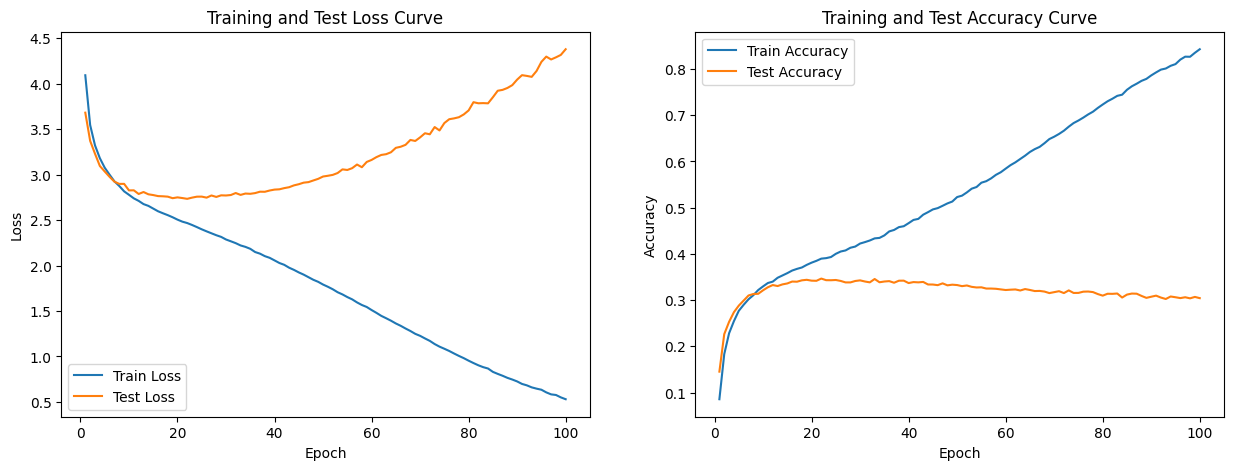

In [6]:
model = CATTransformer(rff_on=True,
                       sigma=2,
                       embed_size=160,
                       heads=5,
                       forward_expansion=8,
                       pre_norm_on=False,
                       mlp_scale_classification=8,
                       embedding_dropout=0.1,
                       decoder_dropout=0,
                       classification_dropout=0.1,
                       targets_classes=target_classes,
                       n_cont=len(cont_columns),
                       cat_feat=unique_classes_per_column).to(device_in_use)
class UncertaintyLoss(nn.Module):
    def __init__(self, num_tasks):
        super(UncertaintyLoss, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1.long()
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]

        task_loss = loss_fn(prediction, target)
        
        return task_loss
def format_metric(value): # Used to format the metrics output
    return f"{value:.5f}"

loss_functions = UncertaintyLoss(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.
epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
test_losses = []
test_accuracies_1 = [] 
test_f1_scores = [] 


#Time will be recorded for all 100 epochs - This means the results will not be comparable to Xgboost but that is ok, we will only compare between transformer models who will also train for 100 epochs
start_time = time.process_time()

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  test_f1_scores.append(f1_1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Accuracy {format_metric(test_accuracy_1)}, F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

total_time = time.process_time() - start_time

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve')
plt.legend()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for income")
print(conf_matrix_1)

best_index = test_accuracies_1.index(max(test_accuracies_1))
print(f"Best accuracy {test_accuracies_1[best_index]}")
print(f"Best F1 {test_f1_scores[best_index]}")
print(f"100 epochs of training and evaluation took, {total_time}")